# Анализ оценок вина

Установка нужных библиотек для машинного обучения:

In [15]:
import importlib.util
import subprocess
import sys

def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

for pkg in ["torch", "pandas", "numpy","matplotlib"]:
    install_if_missing(pkg)

In [16]:
import urllib.request

import os
import math
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [17]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
save_path = "data/winequality-white.csv"

os.makedirs("data", exist_ok=True)

urllib.request.urlretrieve(url, save_path)
print("Файл скачан:", save_path)

wineq_numpy = np.loadtxt(
    save_path,
    dtype=np.float32,
    delimiter=";",
    skiprows=1
)

with open(save_path, "r") as f:
    col_list = next(csv.reader(f, delimiter=";"))

Файл скачан: data/winequality-white.csv


In [18]:
wineq = torch.from_numpy(wineq_numpy)
print(wineq.shape, wineq.dtype)

torch.Size([4898, 12]) torch.float32


In [19]:
seed = 42
g = torch.Generator()
g.manual_seed(seed)

indices = torch.randperm(wineq.size(0), generator=g)

shuffled_data = wineq[indices]
print(shuffled_data, shuffled_data.shape, shuffled_data.dtype)

tensor([[ 6.8000,  0.3200,  0.3400,  ...,  0.4000,  9.1000,  5.0000],
        [ 7.2000,  0.3300,  0.3400,  ...,  0.5300, 13.3000,  7.0000],
        [ 7.3000,  0.2500,  0.2800,  ...,  0.5600, 10.1000,  6.0000],
        ...,
        [ 7.2000,  0.2400,  0.2900,  ...,  0.6400, 11.0000,  7.0000],
        [ 8.0000,  0.2200,  0.3100,  ...,  0.4200, 10.9000,  5.0000],
        [ 6.9000,  0.4100,  0.3300,  ...,  0.5200,  9.4000,  5.0000]]) torch.Size([4898, 12]) torch.float32


Разделение данных на признаки и оценки, а так же нормализация данных

In [20]:
data = shuffled_data[:, :-1]    # Все колонки кроме последней
target = shuffled_data[:, -1].long()   # Только последняя колонка

target_onehot = torch.zeros(target.shape[0], 10) # Создает матрицу высотой target, добавляет ширину 10 для оценок
target_onehot.scatter_(1, target.unsqueeze(1), 1.0)

data_mean = torch.mean(data, dim=0)
data_var = torch.var(data, dim=0)

data_normilized = (data - data_mean) / torch.sqrt(data_var)

data_normilized.shape

torch.Size([4898, 11])

Разделение данных на тренировочные и тестовые

In [21]:
percent = 0.80

train_mount = math.trunc(percent*(data_normilized.shape[0]))
test_mount = data_normilized.shape[0] - train_mount

train_data = data_normilized[0:train_mount, :]
test_data = data_normilized[train_mount:data_normilized.shape[0], :]

train_target_onehot = target_onehot[0:train_mount, :]
test_target_onehot = target_onehot[train_mount:data_normilized.shape[0], :]

print(train_data.shape[0]+test_data.shape[0], '\n', train_target_onehot.shape[0]+test_target_onehot.shape[0])

4898 
 4898


In [22]:
train_dataset = TensorDataset(train_data, train_target_onehot)
test_dataset = TensorDataset(test_data, test_target_onehot)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Создание класса нейросети

In [23]:
class WineNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(WineNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Softmax(dim=1)  # Для классификации (one-hot)
        )
        
    def forward(self, x):
        return self.model(x)

input_dim = train_data.shape[1]
output_dim = train_target_onehot.shape[1]
model = WineNet(input_dim, output_dim)

Функция потерь и оптимизатор:

In [24]:
criterion = nn.CrossEntropyLoss()  # Классификация
optimizer = optim.Adam(model.parameters(), lr=0.001)


Обучение модели

In [25]:
epochs = 150
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        # CrossEntropyLoss ожидает метки, а не one-hot, поэтому:
        y_labels = torch.argmax(y_batch, dim=1)
        loss = criterion(outputs, y_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")


Epoch [5/150] - Loss: 1.9320
Epoch [10/150] - Loss: 1.9171
Epoch [15/150] - Loss: 1.9094
Epoch [20/150] - Loss: 1.9035
Epoch [25/150] - Loss: 1.8984
Epoch [30/150] - Loss: 1.8946
Epoch [35/150] - Loss: 1.8912
Epoch [40/150] - Loss: 1.8887
Epoch [45/150] - Loss: 1.8867
Epoch [50/150] - Loss: 1.8849
Epoch [55/150] - Loss: 1.8833
Epoch [60/150] - Loss: 1.8819
Epoch [65/150] - Loss: 1.8806
Epoch [70/150] - Loss: 1.8796
Epoch [75/150] - Loss: 1.8789
Epoch [80/150] - Loss: 1.8773
Epoch [85/150] - Loss: 1.8763
Epoch [90/150] - Loss: 1.8759
Epoch [95/150] - Loss: 1.8752
Epoch [100/150] - Loss: 1.8735
Epoch [105/150] - Loss: 1.8727
Epoch [110/150] - Loss: 1.8724
Epoch [115/150] - Loss: 1.8719
Epoch [120/150] - Loss: 1.8726
Epoch [125/150] - Loss: 1.8722
Epoch [130/150] - Loss: 1.8712
Epoch [135/150] - Loss: 1.8717
Epoch [140/150] - Loss: 1.8707
Epoch [145/150] - Loss: 1.8707
Epoch [150/150] - Loss: 1.8715


Оценка модели на тесте

In [26]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(y_batch, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 55.41%


Визуализация графика обучения

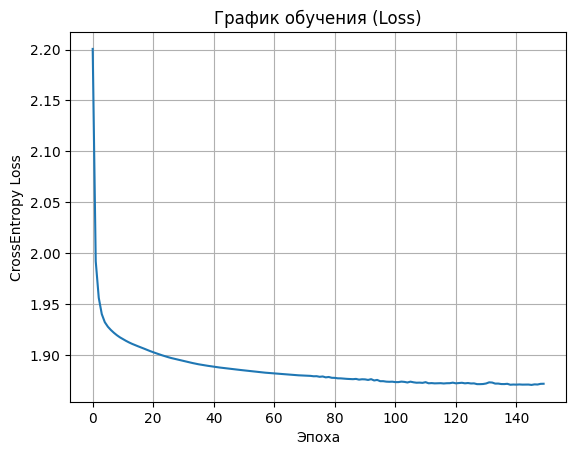

In [27]:
plt.plot(train_losses)
plt.title("График обучения (Loss)")
plt.xlabel("Эпоха")
plt.ylabel("CrossEntropy Loss")
plt.grid(True)
plt.show()